In [153]:
import torch
import torch.nn as nn
import os
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [154]:
# custom dataset class
class npyDataset(Dataset):
    def __init__(self, dataset_path):
        self.Jlist = [os.path.join("np_J", x) for x in os.listdir(dataset_path + r"\np_J")]
        self.Zlist = [os.path.join("np_Z", x) for x in os.listdir(dataset_path + r"\np_Z")]
        self.total_list = self.Jlist + self.Zlist
        self.x = [np.load(os.path.join(dataset_path, k)) for k in self.total_list]              # contain all dataset 
        self.j = np.zeros(len(self.Jlist))  # 0 for J
        self.z = np.ones(len(self.Zlist))   # 1 for Z
        self.y = np.concatenate((self.j, self.z))                                               # contain all label
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        torch_x = torch.from_numpy(self.x[idx]).float()
        torch_y = torch.tensor(self.y[idx]).float().reshape(1)
        return torch_x, torch_y

In [155]:
trainset = npyDataset(r"C:\Users\bell9\Desktop\deep\train")
validset = npyDataset(r"C:\Users\bell9\Desktop\deep\valid")

In [156]:
class Dynamic_predict(nn.Module):
    def __init__(self):
        super(Dynamic_predict, self).__init__()
        self.lstm = nn.LSTM(input_size = 42, hidden_size = 10, batch_first = True, num_layers = 1)
        self.fc = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()
        self.h = None
        self.c = None

    def forward(self, x):
        """
        LSTM > FC_layer > Sigmoid
        """
        h0 = torch.zeros(1, 1, 10)
        c0 = torch.zeros(1, 1, 10)
        out, (h, c)= self.lstm(x, (h0, c0))
        #print(out[-1].shape)
        out = self.fc(out[-1][-1])
        return self.sigmoid(out)

    def test_print(self, x):
        """
        input : 42 length hand coordinate
        output : corresponding Alphabet

        # only for inference
        """
        x = np.array(x)
        hand_x = x[:, :21]
        hand_y = x[:, 21:]
        hand_x = (hand_x - np.min(hand_x)) / (np.max(hand_x) - np.min(hand_x))
        hand_y = (hand_y - np.min(hand_y)) / (np.max(hand_y) - np.min(hand_y))
        cordinate = np.concatenate((hand_x, hand_y))
        cordinate = np.reshape(cordinate, (1, -1, 42))
        cordinate = torch.from_numpy(cordinate)
        with torch.no_grad():
            out = self.forward(cordinate)
            if out < 0.5:
                return "J"
            else :
                return "Z"

In [157]:
model = Dynamic_predict()

In [158]:
# just two classfying, so use Binary Cross Entropy
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0098)

In [159]:
def train(model, train_dataset, valid_dataset, epochs, criterion, optimizer, train_loss, valid_loss):
    for epoch in range(epochs):
        model.train()
        t_loss = 0.0
        for i in range(len(train_dataset)):
            optimizer.zero_grad()        
            data, label = train_dataset[i]
            data = data.reshape((1, -1, 42))
            out = model(data)
            loss = criterion(out, label)
            loss.backward()
            optimizer.step()
            t_loss += loss.item()
        t_loss = t_loss / len(train_dataset)
        print("\nTraining loss :", t_loss)
        v_loss = print_val(model, valid_dataset, criterion)
        train_loss.append(t_loss)
        valid_loss.append(v_loss)


def print_val(model, dataset, criterion):
    model.eval()
    total = len(dataset)
    v_loss = 0.0
    count = 0
    for i in range(len(dataset)):
        data, label = dataset[i]
        data = data.reshape((1, -1, 42))
        out = model(data)
        if out < 0.5 and label == 0:
            count += 1
        if out >= 0.5 and label == 1:
            count += 1
        loss = criterion(out, label)
        v_loss += loss.item()
    v_loss = v_loss / len(dataset)
    print("Valid loss : ", v_loss)
    print('Accuracy of the network on the %d test images: %d %%' % (total,
        100.0 * count / total))    
    return v_loss
            
    
    

In [160]:
train_loss = []
valid_loss = []

train(model, trainset, validset, 10, criterion, optimizer, train_loss, valid_loss)


Training loss : 0.5096081756265955
Valid loss :  1.1343242439130943
Accuracy of the network on the 60 test images: 46 %

Training loss : 0.7916468965947329
Valid loss :  0.80505700558424
Accuracy of the network on the 60 test images: 46 %

Training loss : 0.37086958559838373
Valid loss :  0.8481583667298158
Accuracy of the network on the 60 test images: 46 %

Training loss : 0.21941478243425264
Valid loss :  0.48831005295117696
Accuracy of the network on the 60 test images: 76 %

Training loss : 0.1734556336910581
Valid loss :  0.14184352004279693
Accuracy of the network on the 60 test images: 95 %

Training loss : 0.11057990451516518
Valid loss :  0.04041787915242215
Accuracy of the network on the 60 test images: 100 %

Training loss : 0.0593707298897394
Valid loss :  0.02818792564794421
Accuracy of the network on the 60 test images: 100 %

Training loss : 0.04923216354139336
Valid loss :  0.022263094736263155
Accuracy of the network on the 60 test images: 100 %

Training loss : 0.04

In [161]:
# model save

checkpoint_dir = './pt-checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
pt_path = os.path.join(checkpoint_dir, "last_model.pt")
torch.save(model.state_dict(), pt_path)

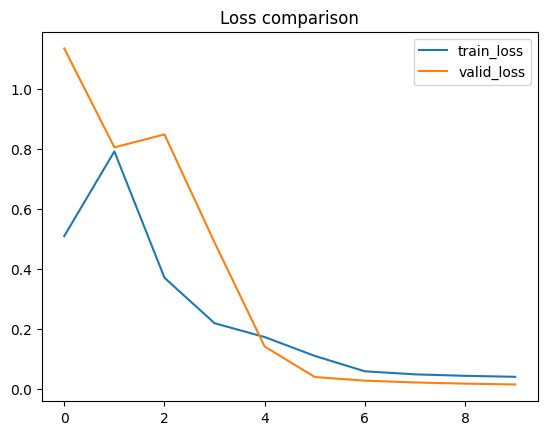

In [162]:
# loss visualization

epochs = range(10)
plt.plot(epochs, train_loss, label = "train_loss")
plt.plot(epochs, valid_loss, label = "valid_loss")
plt.title("Loss comparison")
plt.legend()
plt.show()
